# 03. Modeling (Feature Elimination)

---
### Problem Statement

[Zillow](https://www.zillow.com), a real estate database company offers what they call 'Zestimate'. According to Zillow, Zestimate is an estimate on property value from their 'public and user submitted data taking into account home facts, location and market conditions'. How can we make predictions like Zestimate? What can we do to improve the predictions?        

<img src = "./image/zillow.png" width="350"/>

In this project, I build regression model **clean_train_engineered_terms.csv** dataset to study how to make predictions of property value like Zestimate and how to optimize the predictions. **clean_train_engineered_terms.csv** is the dataset that was cleaned and engineered features were added. 


In [39]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import functions as fc

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNetCV
from sklearn import metrics

%matplotlib inline

In [2]:
# Read in train data

df = pd.read_csv('./datasets/clean_train_engineered_terms.csv')

In [8]:
df.shape

(2051, 25203)

### Baseline Modeling

Baseline model is when sale price of all properties is predicted to be the average of the known sale prices.

In [3]:
X = df.drop(['Id', 'PID', 'SalePrice'], axis=1)
y = df['SalePrice'] 

In [4]:
y_hat = np.mean(y)
y_hat = [y_hat]*len(y)

In [5]:
fc.six_reg_metrics(X, y, y_hat)

{'MAE': 58358.94084226196,
 'SSE': 12877966918785.385,
 'MSE': 6278872217.837828,
 'RMSE': 79239.33504161824,
 'R2': 0.0,
 'Adjusted_R2': 1.0885529157667386}

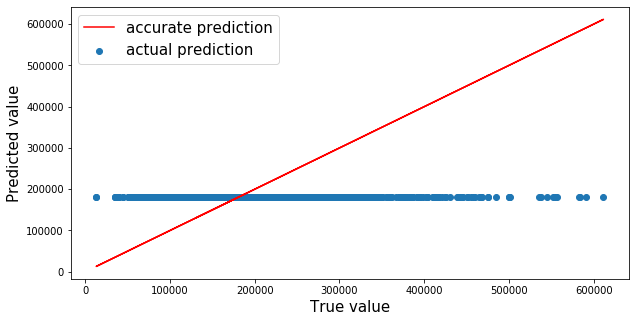

In [6]:
fc.accuracy_plot(y, y_hat)

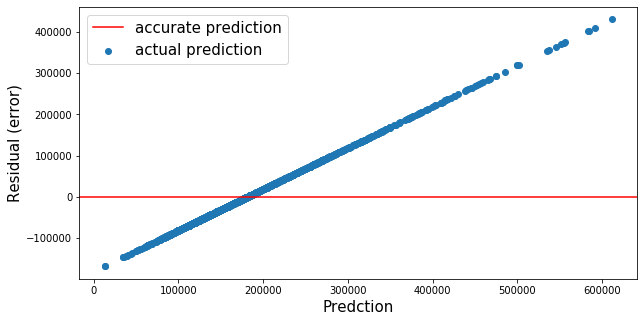

In [7]:
resids = y - y_hat 
fc.resid_plot(y, resids)

### Lasso Linear Regression Model (L1 penalty)
The dataset has 25203 features after all engineered features are added. Lasso Linear Regression is used to identify features that are not important and the unimportant features can be eliminated.

In [81]:
X = df.drop(['Id', 'PID', 'SalePrice'], axis = 1)
y = df['SalePrice']

In [82]:
rs = 112

ss = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rs)

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [83]:
lasso = LassoCV(n_alphas = 200, 
                cv = 5)
lasso.fit(X_train_scaled, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=200, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

Trial 1
Train Score: 0.8990754636024897
Test Score: 0.8956800711331429
RMSE: 25308.63376610398
Trial 2
Train Score: 0.9615081990958385
Test Score: 0.40652095433649577
RMSE: 64906.186789889754


/Users/dae/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 997325498.3277588, tolerance: 918833148.2284666
  positive)


Trial 3
Train Score: 0.9525833946012381
Test Score: 0.9314325093326864
RMSE: 22191.11139925936


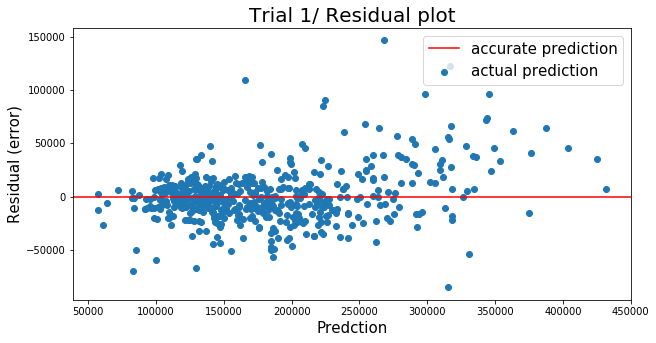

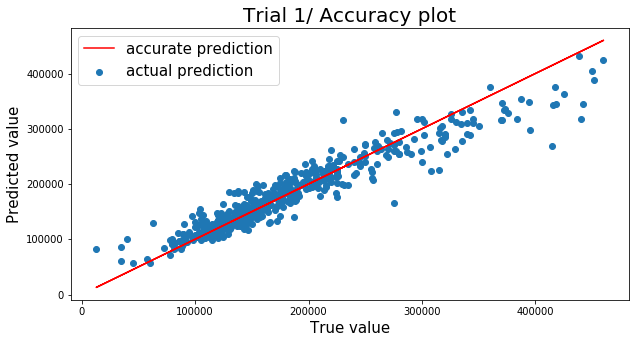

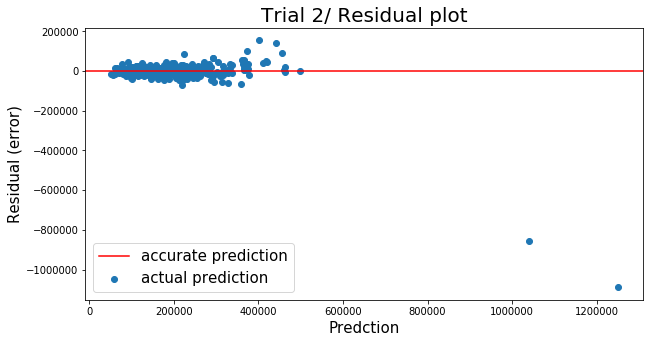

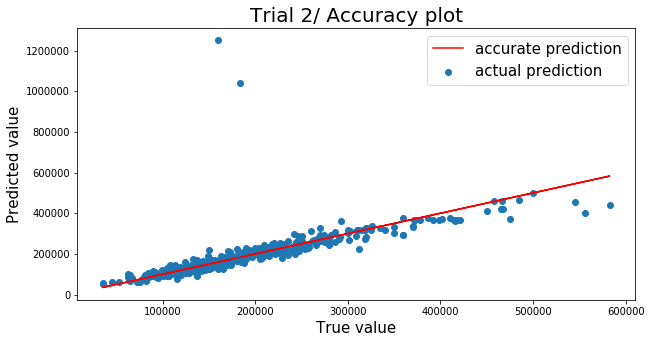

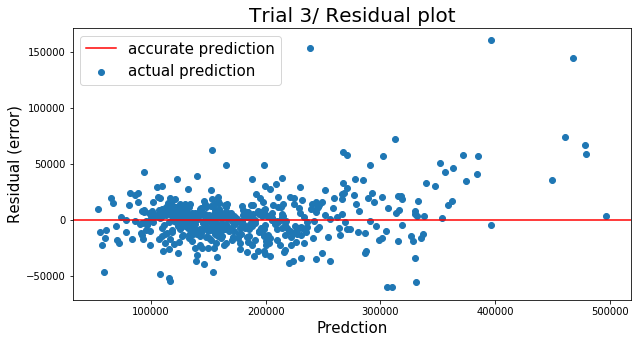

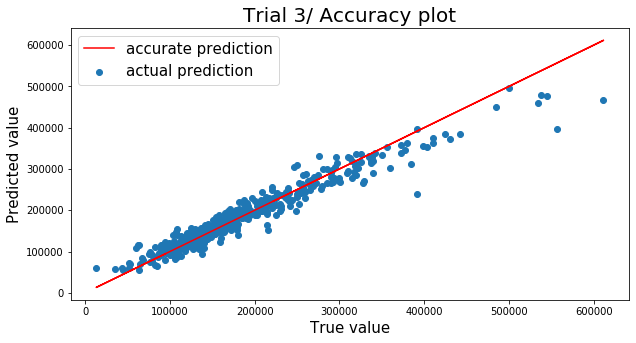

In [84]:
fc.model_fit_sc(X, y, model = lasso)

Observations:
- Some outliers seem to impact the model's performance (Refer to Trial 2)
- There isn't a big sign of overfitting (low variance). It is likley that most features were technically dropped using the penalty term. This possibility is examined below.

In [85]:
# Check the coefficient for each features
coef_dict = dict(zip(X.columns, lasso.coef_))
coef_df = pd.DataFrame(data = list(coef_dict.items()), columns = ['feature', 'coef'])
coef_df['abs_coef'] = abs(coef_df['coef'])
coef_df.sort_values(by = 'abs_coef', ascending = False)

,feature,coef,abs_coef
8289,Misc Val Bsmt Exposure_Gd,-12977.223829,12977.223829
1345,Overall Qual Gr Liv Area,9869.555658,9869.555658
2392,Mas Vnr Area Pool QC_Gd,-5969.838639,5969.838639
4704,Gr Liv Area Kitchen Qual,5938.388452,5938.388452
1562,Overall Cond Gr Liv Area,5721.333512,5721.333512
...,...,...,...
8475,Mo Sold Bsmt Exposure_no,0.000000,0.000000
8474,Mo Sold Bsmt Exposure_No,-0.000000,0.000000
8473,Mo Sold Bsmt Exposure_Mn,-0.000000,0.000000
8472,Mo Sold Bsmt Exposure_Gd,0.000000,0.000000


In [86]:
# Check features that have absolute coefficient larger than 0
coef_df.loc[coef_df['abs_coef'] != 0,:].sort_values('abs_coef', ascending = False)

,feature,coef,abs_coef
8289,Misc Val Bsmt Exposure_Gd,-1.297722e+04,1.297722e+04
1345,Overall Qual Gr Liv Area,9.869556e+03,9.869556e+03
2392,Mas Vnr Area Pool QC_Gd,-5.969839e+03,5.969839e+03
4704,Gr Liv Area Kitchen Qual,5.938388e+03,5.938388e+03
1562,Overall Cond Gr Liv Area,5.721334e+03,5.721334e+03
...,...,...,...
10660,Lot Shape_IR3 Sale Type_New,-4.541560e-13,4.541560e-13
18979,Exterior 1st_Stucco Sale Type_New,-4.541560e-13,4.541560e-13
20430,Exterior 2nd_Stucco Pool QC_Gd,-3.027707e-13,3.027707e-13
12780,Condition 1_Feedr Pool QC_Gd,-3.027707e-13,3.027707e-13


In [97]:
# Get feature names after removing the features that were penalized to 0 with Lasso (L1 penalty)
imp_cols = list(coef_df.loc[coef_df['abs_coef'] != 0,:].sort_values('abs_coef', ascending = False)['feature'])

In [99]:
# Save features selected from Lasso regression in a csv file
df[imp_cols].to_csv("./datasets/lasso_selected_features.csv", index = False)

### Ridge Linear Regression Model (L2 Penalty)
Lisso linear regression shrinks the cofficient of unimportant features to 0. After removing features with cofficient of 0, 238 features were left. The 238 features will be used in Ridge linear regression.

In [88]:
X = X.loc[:, imp_cols]

ss = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rs)

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [89]:
ridge_alphas = np.logspace(0, 5 ,100)

ridge = RidgeCV(alphas = ridge_alphas, cv = 5) 

Trial 1
Train Score: 0.9527152241307072
Test Score: 0.9443454200393697
RMSE: 18485.68357711816
Trial 2
Train Score: 0.9577037030542873
Test Score: 0.8669390148073796
RMSE: 30733.269745981605
Trial 3
Train Score: 0.9651609412989449
Test Score: 0.9251714876357848
RMSE: 23182.13770019987


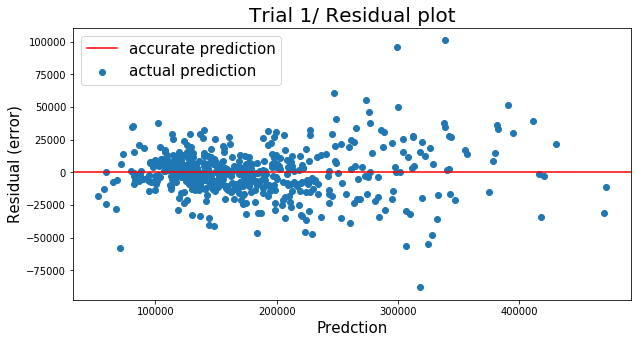

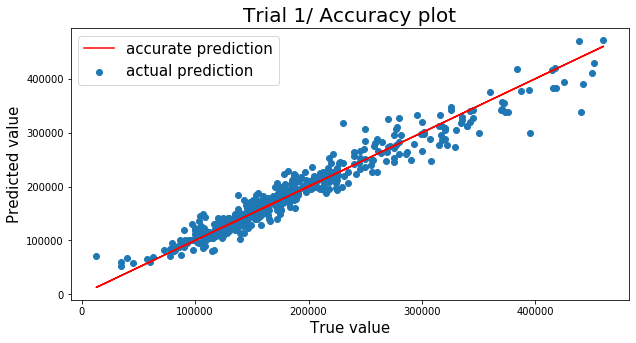

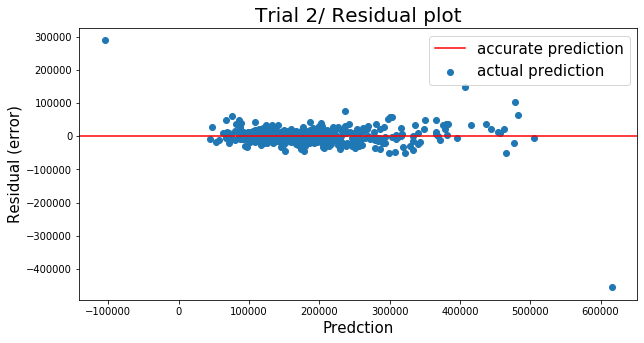

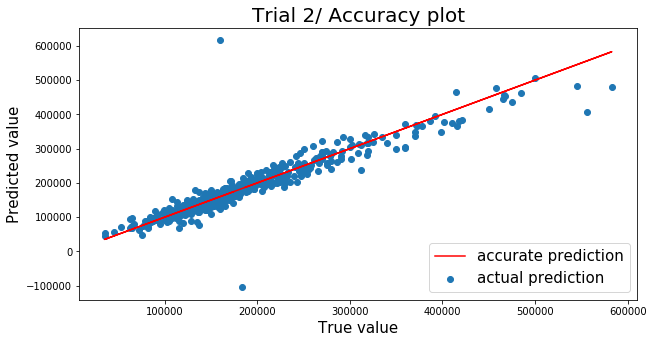

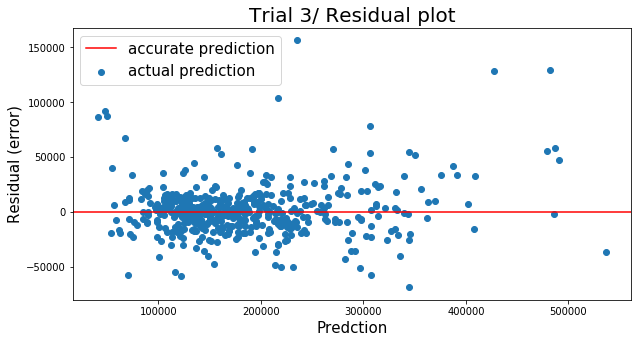

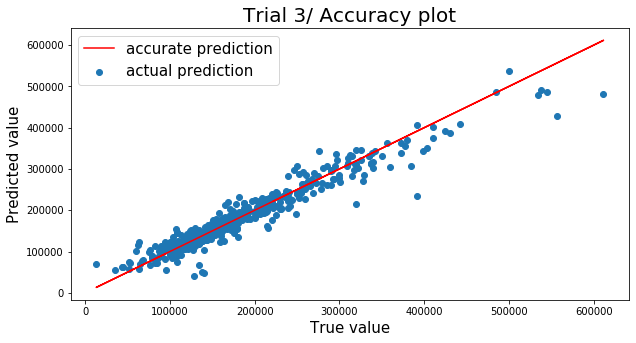

In [90]:
fc.model_fit_sc(X, y, model = ridge)

Observations:
- The two outliers observed in Lisso regression model are still there (Refer to Trial 2)
- There isn't a big sign of overfitting (low variance). 
- The Ridge regression model performs better than Lisso regression model.
- From the residual plots, it is shown that the residuals are larger when the actual sale price of the propoerty is larger.

In [91]:
# Make dataframe with Ridge coefficient weight

coef_dict = dict(zip(X.columns, ridge.coef_))
coef_df = pd.DataFrame(data = list(coef_dict.items()), columns = ['feature', 'coef'])
coef_df['abs_coef'] = abs(coef_df['coef'])
print("Ridge model result:")
coef_df.sort_values(by = 'abs_coef', ascending = False)

Ridge model result:


,feature,coef,abs_coef
0,Misc Val Bsmt Exposure_Gd,-16089.696517,16089.696517
1,Overall Qual Gr Liv Area,15921.135338,15921.135338
20,1st Flr SF age_when_sold,-9036.671489,9036.671489
164,Garage Cars Sale Type_New,-7713.493346,7713.493346
4,Overall Cond Gr Liv Area,7556.484754,7556.484754
...,...,...,...
149,Fireplaces Sale Type_Con,93.528214,93.528214
132,Bldg Type_Duplex Garage Finish_Unf,-68.074293,68.074293
190,BsmtFin Type 1_GLQ Fireplace Qu_Gd,-37.948141,37.948141
176,House Style_2Story Garage Type_Detchd,-37.784396,37.784396


### Elastic Net
Elastic Net combines penalties of Lasso regression (L1 penalty) and Ridge (L2 penalty) to get the best of both.

In [92]:
elastic_alphas = np.logspace(0, 5 ,100)

elastic = ElasticNetCV(alphas = elastic_alphas, cv = 5)

In [ ]:
X = X.loc[:, imp_cols]

ss = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rs)

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

Trial 1
Train Score: 0.9498555059124479
Test Score: 0.9436383196662702
RMSE: 18602.744719287504
Trial 2
Train Score: 0.9529565239857947
Test Score: 0.8858945495492175
RMSE: 28460.11137618556
Trial 3
Train Score: 0.9571503030021037
Test Score: 0.9218840464097243
RMSE: 23685.89473777486


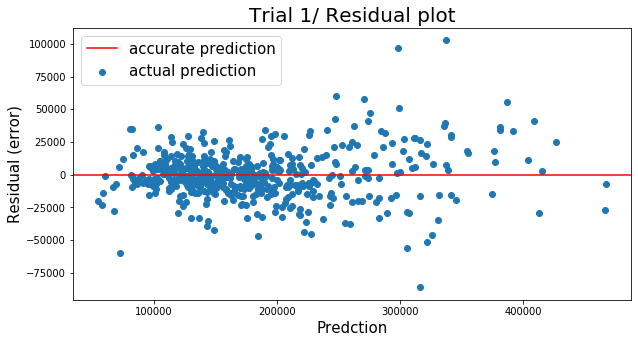

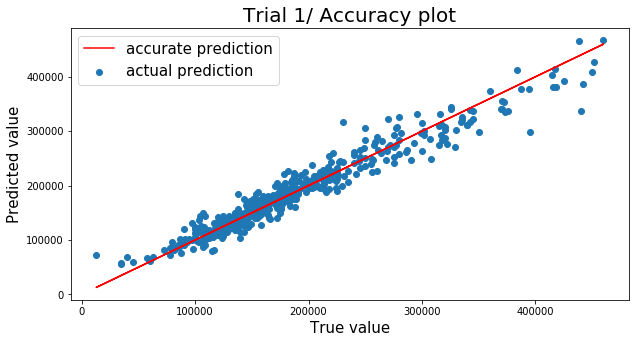

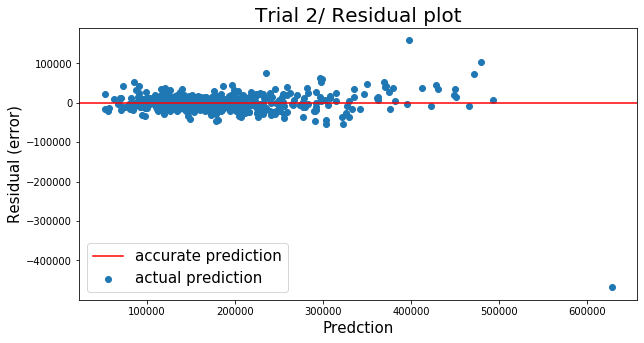

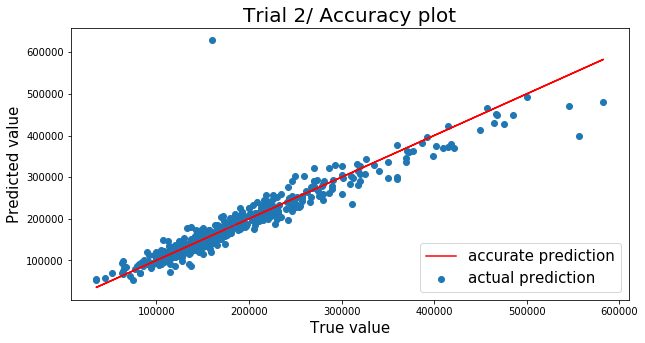

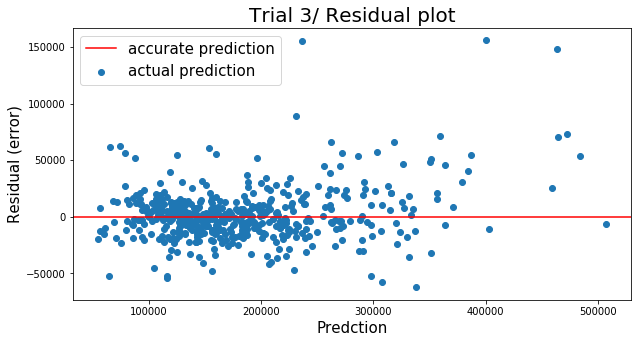

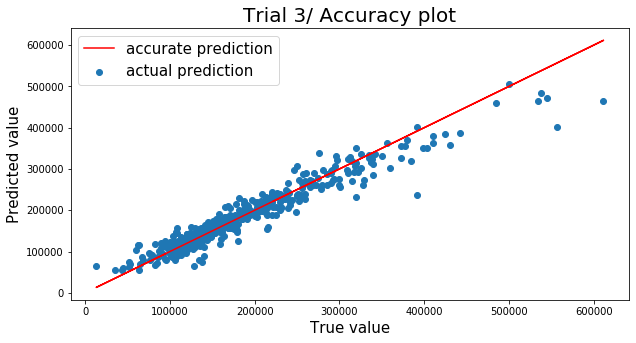

In [44]:
fc.model_fit_sc(X, y, model = elastic)

Observations:
- The two outliers observed in Lisso regression model and Ridge regression model are still there (Refer to Trial 2)
- Elastic Net model's performance is not too different from how Ridge model performed.
- From the residual plots, it is shown that the residuals are larger when the actual sale price of the propoerty is larger.

### Data Cleaning (2)
This data cleaning process is to tackle the two issues I observed from the modeling work above.

1. In trial 2 of every model I tried above (Lisso, ridge, elastic net), one or two outliers were observed. I will look at the outliers below.
2.  The more expensive the actual sale price of the properties is the larger the errors from the predictions were. I will examine why might we see this pattern and attemp to resolve the issue.

#### 1. Outlier Handling

In [65]:
# Test LassoCV with random state = 112 to simulate the trial 2 model test result.

rs = 112

ss = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rs)

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

lr = LassoCV(n_alphas = 200, cv = 5)

lr.fit(X_train_sc, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=200, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [67]:
X_test['preds'] = lr.predict(X_test_sc)
X_test['resids'] = y_test.loc[:] - X_test.loc[:,'preds']

/Users/dae/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/dae/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [68]:
# Checking out the outlier
X_test['preds'].nlargest(5)

960     640104.753283
800     507806.155448
138     482815.261961
190     477603.786042
1796    476377.654056
Name: preds, dtype: float64

In [69]:
# Checking out the outlier

X_test['resids'].nsmallest(5)

960    -480104.753283
1897    -58050.719532
1201    -50503.772705
845     -46044.225270
689     -43800.105865
Name: resids, dtype: float64

In [76]:
# Test RidgeCV with random state = 112 to simulate the trial 2 model test result.

rs = 112

ss = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rs)

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

ridge_alphas = np.logspace(0, 5 ,100)

ridge = RidgeCV(alphas = 200, cv = 5) 

ridge.fit(X_train_sc, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [78]:
X_test['preds'] = ridge.predict(X_test_sc)
X_test['resids'] = y_test.loc[:] - X_test.loc[:,'preds']

/Users/dae/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/dae/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [79]:
# Checking out the outlier
X_test['preds'].nlargest(5)

1796    564195.643147
1897    524237.481824
800     515354.876143
138     497988.222388
1700    494852.200510
Name: preds, dtype: float64

In [80]:
# Checking out the outlier

X_test['resids'].nsmallest(5)

1897   -109237.481824
845     -61591.721917
1232    -54421.730772
689     -47127.036033
1167    -45037.085760
Name: resids, dtype: float64

In [93]:
# Test RidgeCV with random state = 112 to simulate the trial 2 model test result.

rs = 112

ss = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rs)

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

elastic_alphas = np.logspace(0, 5 ,100)

elastic = ElasticNetCV(alphas = elastic_alphas, cv = 5) 

elastic.fit(X_train_sc, y_train)

ElasticNetCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.149757...
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
             copy_X=True, cv=5, eps=0.001, fit_intercept=True, l1_ratio=0.5,
             max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
             positive=False, precompute='auto', random_state=None,
             selection='cyclic', tol=0.0001, verbose=0)

In [94]:
X_test['preds'] = elastic.predict(X_test_sc)
X_test['resids'] = y_test.loc[:] - X_test.loc[:,'preds']

/Users/dae/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/dae/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [95]:
# Checking out the outlier
X_test['preds'].nlargest(5)

960     628598.282487
800     493686.313455
1796    480048.673645
138     471817.561217
190     466460.897525
Name: preds, dtype: float64

In [96]:
# Checking out the outlier
X_test['resids'].nsmallest(5)

960    -468598.282487
845     -53858.927152
32      -52819.727808
1167    -45259.286537
1232    -45087.287936
Name: resids, dtype: float64

### Linear Regression Model

In [8]:
all_cols = list(df.drop(['Id', 'PID'], axis=1).columns)

In [ ]:
fc.corr_r2_plot(dataframe = df, cols = all_cols,
             title_name = 'All Features (+ interaction terms)',
             corr_start = 0.1,
             corr_end = 0.7,
             corr_step = 0.055)

In [ ]:
coef_corr_plot(dataframe = df, cols = all_cols, absolute = True)